In [1]:
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/GaussFit_spec2D.py
%run /Users/hhg/Research/kinematic_lensing/code/BinnedFit/ChainTool.py

%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/Users/hhg/Research/kinematic_lensing/code/BinnedFit/")
from binnedFit_utilities import *

dir_tfCube: /Users/hhg/Research/kinematic_lensing/repo/KLens


In [2]:
sys.path.append("/Users/hhg/Research/kinematic_lensing/repo/kl_measurement/scripts/")
from parameter_class import fit_parameters
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import emcee
import chisq
from generate_TFcube import get_TFcube_pars, get_data_TFcube

In [12]:
sini = 0.761
g1 = 0.0
g2 = 0.2

eint_thy = cal_e_int(sini=sini)
eobs_thy = cal_e_obs(e_int=eint_thy, gamma_p=g1)
theta_obs = cal_theta_obs(e_int=eint_thy, gamma_x=g2)

slitAng_major_p = theta_obs #0.001 #theta_obs    
slitAng_minor_p = theta_obs + np.pi/2. #np.pi/2. #theta_obs + np.pi/2.

bestfit_e_obs = eobs_thy
print("eobs_thy:", eobs_thy)
print("slitAng_major_p:", slitAng_major_p*180./np.pi)
print("slitAng_minor_p:", slitAng_minor_p*180./np.pi)

eobs_thy: 0.38499950250817866
slitAng_major_p: 29.764079766240826
slitAng_minor_p: 119.76407976624081


In [13]:
update_TF, _ = get_TFcube_pars()

#update_TF['slitAngles'] = np.array([slitAng_minor_p]) 
update_TF['slitAngles'] = np.array([90./180.*np.pi])
#update_TF['slitAngles'] = np.array([slitAng_major_p]) 

update_TF['g1'] = g1
update_TF['g2'] = g2
update_TF['sini'] = sini
update_TF['vcirc'] = 200. 

update_TF['n_knots'] = 25.
update_TF['knot_fraction'] = 0.0
update_TF['throughput'] = 0.29
update_TF['slitWidth'] = 0.05
update_TF['psfFWHM'] = 0.5
update_TF['pixScale'] = 0.1185# 0.1185  # 0.032 

update_TF['redshift'] = 0.2
update_TF['Resolution'] = 6000.
update_TF['nm_per_pixel'] = 0.033 #0.033 # 0.025
update_TF['expTime'] = 3600.0 
update_TF['linelist']['flux'][update_TF['linelist']['species'] == 'Halpha'] = 6.0e-24
update_TF['lambda_min'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] - 2
update_TF['lambda_max'] = (1 + update_TF['redshift']) * update_TF['linelist']['lambda'][update_TF['linelist']['species'] == 'Halpha'] + 2
update_TF['norm'] = 0.
update_TF['ngrid'] = 256
update_TF['image_size'] = 128

TF_pars, meta_parameters = get_TFcube_pars(update_TF)

%time data, noise, obslambda = get_data_TFcube(TF_pars, meta_parameters, return_lambda=True)


# make data_info from Prangal's data output

data_info = {}
data_info['ModelCube'] = None
data_info['ObsCube'] = None
data_info['image'] = data['image']
data_info['image_variance'] = noise['image']

if len(TF_pars['slitAngles']) == 1:
    data_info['data'] = data['spectra'][0]
else:
    #data_info['data'] = data['spectra'][0] # this line is to make it compatible with older branches... 
    data_info['data_major'] = data['spectra'][0]
    data_info['data_minor'] = data['spectra'][1]
    
data_info['grid_lambda'] = obslambda

extent =  TF_pars['image_size'] * TF_pars['pixScale']
subGridPixScale = extent*1./TF_pars['ngrid']

data_info['grid_pos']    = np.arange(-extent/2., extent/2., subGridPixScale)
data_info['grid_Image']  = np.arange(-extent/2., extent/2., TF_pars['pixScale'])
data_info['par_fid']     = TF_pars
data_info['lambda_emit'] = 656.461 # Halpha [nm]

returning:
lambda, observation, model, sky (the last three are (npix, npix, nspax) datacubes)
CPU times: user 6.64 s, sys: 41.7 ms, total: 6.68 s
Wall time: 5.36 s


In [14]:
def get_grid_velocity(grid_labmda, lambda_cen):
    grid_z = grid_labmda/lambda_cen - 1.
    c_kms = 299792.458
    grid_v = grid_z*c_kms
    return grid_v

# Plot spectrum (velocity unit)

In [15]:
GaussFit = GaussFit_spec2D(data_info)

fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D(data=GaussFit.data)
model = GaussFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)
data = GaussFit.data

# get pixel edges
lambda_min = np.min(GaussFit.grid_lambda)  ; lambda_MAX = np.max(GaussFit.grid_lambda)
x_min = np.min(GaussFit.grid_pos)          ; x_MAX = np.max(GaussFit.grid_pos)

lambda_cen = data_info['lambda_emit']*(1.+data_info['par_fid']['redshift'])

grid_velocity = get_grid_velocity(grid_labmda=GaussFit.grid_lambda, lambda_cen=lambda_cen)

time cost in gaussFit_spec2D: 0.2208249568939209 (secs)


In [16]:
fitted_peakVelocity = get_grid_velocity(grid_labmda=fitted_peakLambda, lambda_cen=lambda_cen)

In [17]:
fitted_lambda_up = fitted_peakLambda+fitted_sigma
fitted_lambda_lo = fitted_peakLambda-fitted_sigma

fitted_velocity_lo = get_grid_velocity(grid_labmda=fitted_lambda_up, lambda_cen=lambda_cen) - fitted_peakVelocity
fitted_velocity_up = fitted_peakVelocity - get_grid_velocity(grid_labmda=fitted_lambda_lo, lambda_cen=lambda_cen) 

fitted_velocity_error = np.vstack((fitted_velocity_lo, fitted_velocity_up))
fitted_velocity_error.shape

(2, 256)

(-200.0, 200.0)

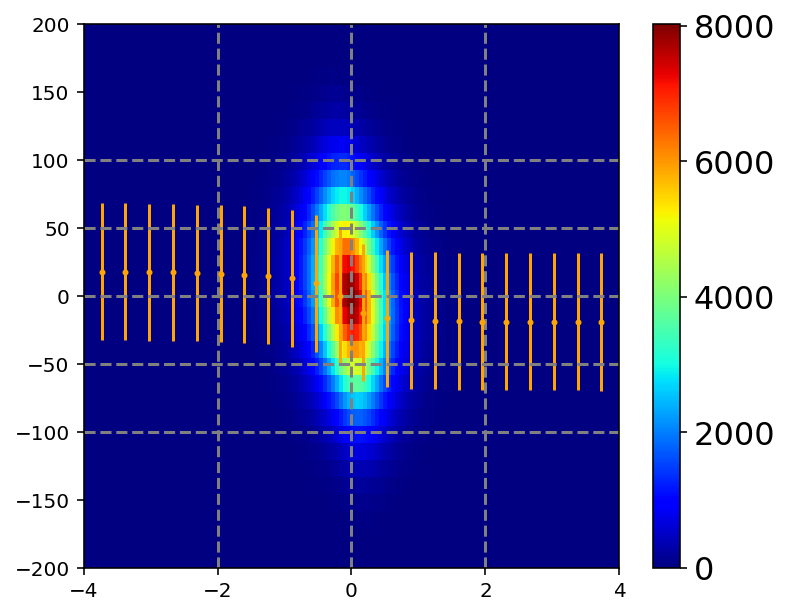

In [18]:
#%matplotlib
%matplotlib inline

ncol=1

fig,ax = plt.subplots(1,1,figsize=(6,5))
plt.rc('font',size=16)

POS, VEL = np.meshgrid(GaussFit.grid_pos, grid_velocity)  # VEL, POS = np.meshgrid(grid_velocity, GaussFit.grid_pos)
img0=ax.pcolormesh(POS, VEL, data.T, cmap='jet')          # img0 = ax.pcolormesh(POS, VEL, data, cmap='Greys')

#### gaussfit image peak identification summary (yellow)
ax.errorbar(GaussFit.grid_pos[5::6], fitted_peakVelocity[5::6], yerr = fitted_velocity_error[:,5::6], color='orange', marker='o', markersize=2, ls='none', label='gauss1D fit on 2D spec')

ax.axhline(0., color='gray',ls='--')
ax.axhline(100., color='gray',ls='--')
ax.axhline(-100., color='gray',ls='--')
ax.axvline(0., color='gray',ls='--')
ax.axvline(2., color='gray',ls='--')
ax.axvline(-2., color='gray',ls='--')
ax.axhline(50., color='gray',ls='--')
ax.axhline(-50., color='gray',ls='--')

fig.colorbar(img0, ax=ax)
ax.set_xlim((-4, 4))
ax.set_ylim((-200., 200.))

# Plot spectrum (lambda unit)

In [10]:
GaussFit = GaussFit_spec2D(data_info)

fitted_peakLambda, fitted_amp, fitted_sigma = GaussFit.gaussFit_spec2D(data=GaussFit.data)
model = GaussFit.model_spec2D(fitted_peakLambda,fitted_amp,fitted_sigma)
data = GaussFit.data

# get pixel edges
lambda_min = np.min(GaussFit.grid_lambda)  ; lambda_MAX = np.max(GaussFit.grid_lambda)
x_min = np.min(GaussFit.grid_pos)          ; x_MAX = np.max(GaussFit.grid_pos)

time cost in gaussFit_spec2D: 0.2060859203338623 (secs)


/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/hhg/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


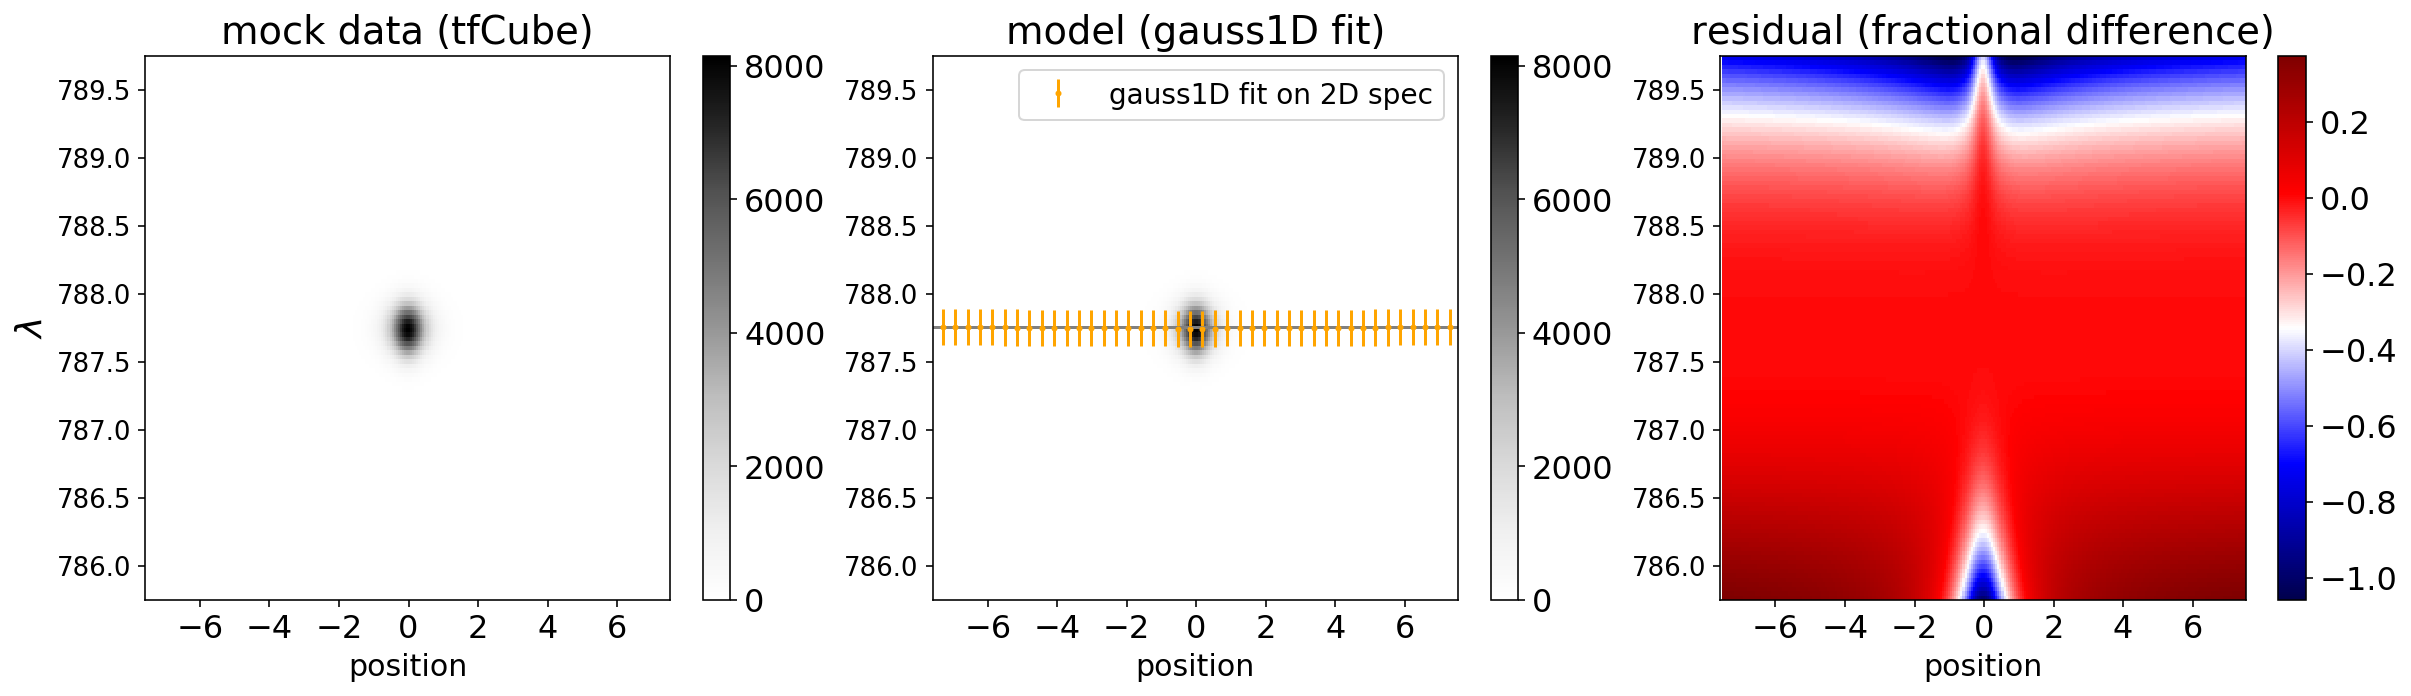

In [11]:
#%matplotlib
%matplotlib inline

ncol=3

fig,ax = plt.subplots(1,ncol,figsize=(20,5))
plt.rc('font',size=16)

img0=ax[0].imshow(data.T , extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img1=ax[1].imshow(model.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap='Greys', origin="lower")
img2=ax[2].imshow((data.T-model.T)/data.T, extent=[x_min, x_MAX, lambda_min, lambda_MAX ], aspect='auto',cmap=plt.cm.seismic, origin="lower")
fig.colorbar(img2, ax=ax[2])
fig.colorbar(img0, ax=ax[0])
fig.colorbar(img1, ax=ax[1])

#### gaussfit image peak identification summary (yellow)
ax[1].errorbar(GaussFit.grid_pos[5::6], fitted_peakLambda[5::6], fitted_sigma[5::6] ,color='orange', marker='o', markersize=2,ls='none',label='gauss1D fit on 2D spec')

ax[1].axhline(lambda_cen, color='gray')

for j in range(ncol):
    #ax[j].set_ylim(vcen-1.5,vcen+1.5)
    #ax[j].set_xlim(-3.5,3.5)
    ax[j].set_xlabel('position', fontsize=15)
    ax[j].tick_params(axis='x', labelsize=16)
    ax[j].tick_params(axis='y', labelsize=13)
    ax[j].set_xticks([-6, -4, -2, 0, 2, 4, 6])

ax[0].set_ylabel(r'$\lambda$', fontsize=18)    
ax[0].set_title('mock data (tfCube)')
ax[1].set_title('model (gauss1D fit)')
ax[2].set_title('residual (fractional difference)')

#ax[1].legend(loc=(2.3,0.75),prop={'size':16})
ax[1].legend(loc="best",prop={'size':14})

plt.show()